In [26]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

### Load the trainer

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_multiway_prompting.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [27]:
using_colab = False

In [28]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys

sam3_root = "/home/kalyanv/sam3"
sys.path.append(f"{sam3_root}/examples")

from utils import draw_box_on_image, show_img_tensor, plot_bbox, plot_mask, COLORS, plot_results, normalize_bbox

In [32]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# Build Model

In [45]:
from sam3 import build_sam3_image_model

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
checkpoint_path = f"{sam3_root}/assets/checkpoints/paper_ckpt_model_only_from_fair_sc.pt"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path)

In [46]:
from sam3.model.sam3_image_processor import Sam3Processor

image_path = f"{sam3_root}/assets/images/test_image.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

# Visual prompt (Box)

Normalized box: [[0.375      0.40277778 0.0859375  0.5       ]]


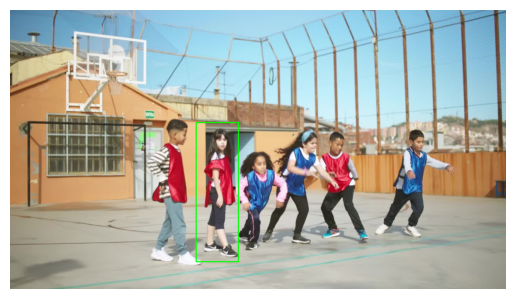

In [47]:
box_input_xywh = [480.0, 290.0, 110.0 , 360.0] # Here the point is in top-left corner, w, h format.


norm_box_xywh = box_input_xywh / np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
print("Normalized box:", norm_box_xywh)

processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(state=inference_state, box=normalize_bbox(box_input_xywh, width, height), label=True)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh )
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

found 6 object(s)


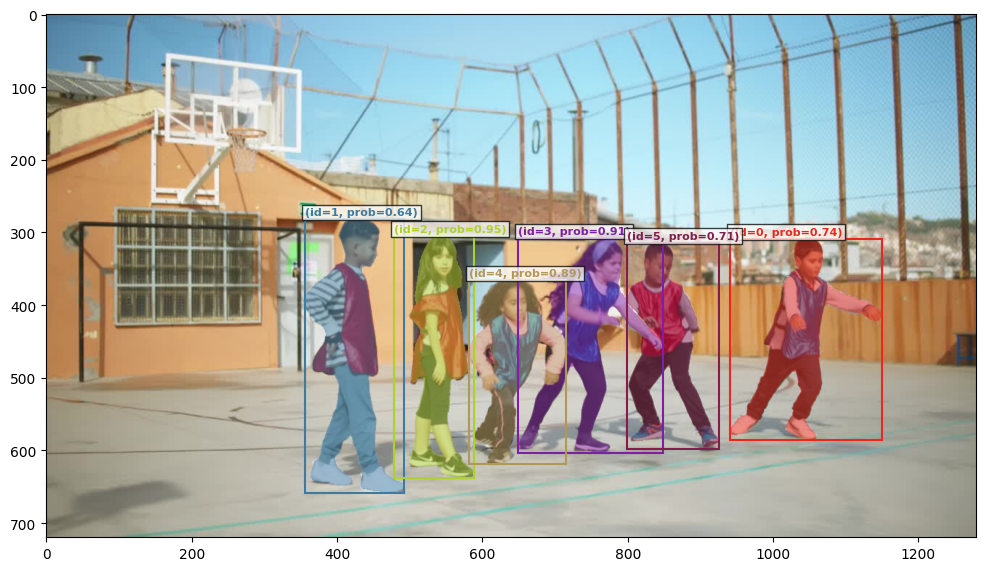

In [48]:
plot_results(img0, inference_state)

# Multi-box prompting (with positive and negative boxes)

Normalized box: [[0.375      0.40277778 0.0859375  0.5       ]]


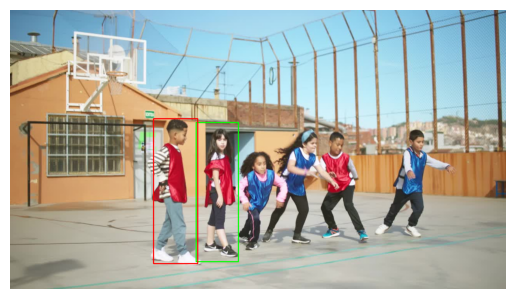

In [49]:
box_input_xywh = [[480.0, 290.0, 110.0 , 360.0],[370.0, 280.0, 115.0 , 375.0]]
box_labels = [True, False]

print("Normalized box:", norm_box_xywh)
processor.reset_all_prompts(inference_state)

for box, label in zip(box_input_xywh, box_labels):
    inference_state = processor.add_geometric_prompt(state=inference_state, box=normalize_bbox(box, width, height), label=label)

img0 = Image.open(image_path)
image_with_box = img0
for i in range(len(box_input_xywh)):
    if box_labels[i] == 1:
        color = (0,255,0)
    else:
        color = (255,0,0)
    image_with_box = draw_box_on_image(image_with_box, box_input_xywh[i],color )
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

found 5 object(s)


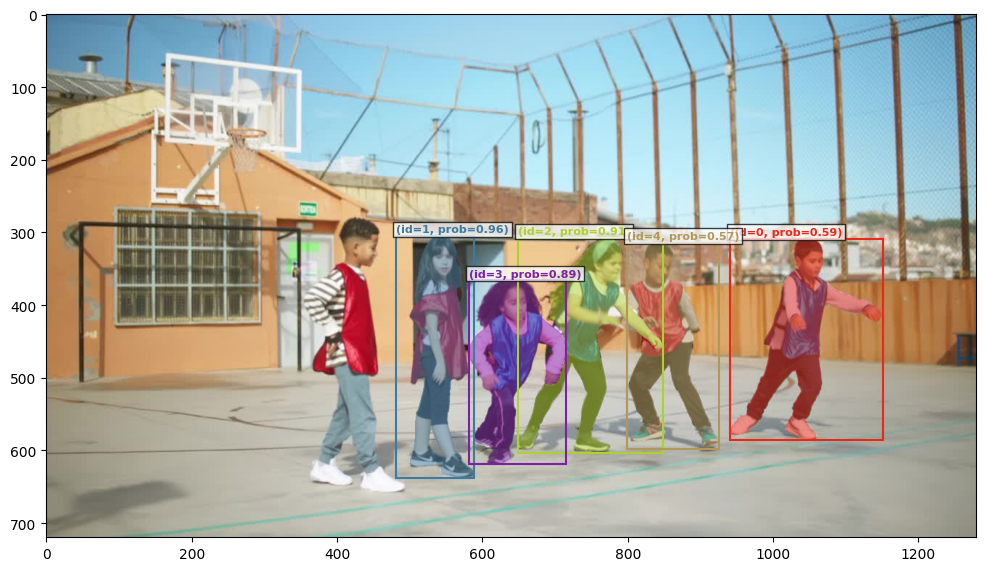

In [50]:
plot_results(img0, inference_state)

# Text prompt

found 12 object(s)


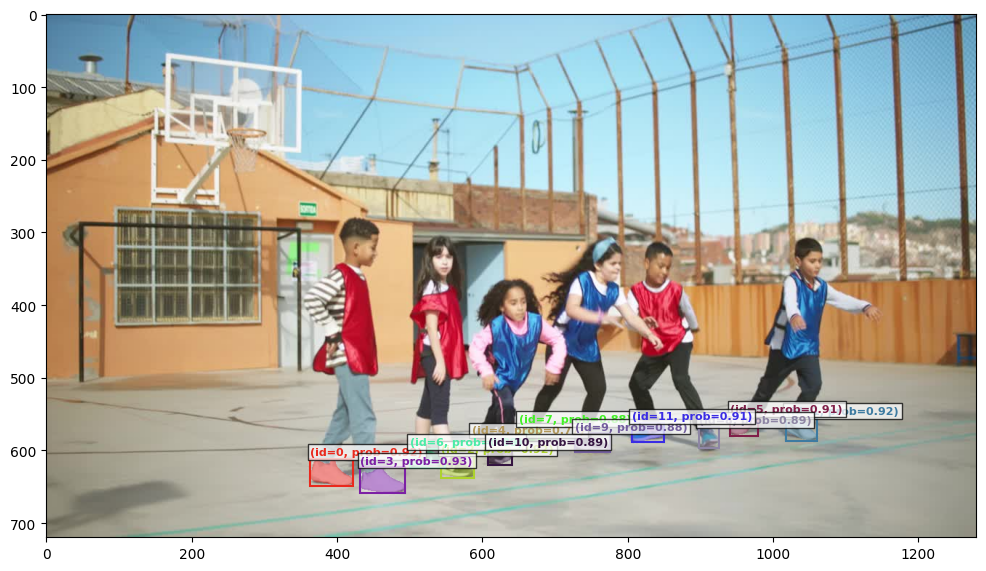

In [51]:
processor.reset_all_prompts(inference_state)
inference_state= processor.set_text_prompt(state =inference_state, prompt="shoe")


img0 = Image.open(image_path)
plot_results(img0, inference_state)
